# Explore surface CREG025.L75 experiments to assess the AW subduction
>> ## Compute climatological ans seasonal maps of Qnet, AWTmax & Ice [] 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import CREG_maps_func as cregmap
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from netCDF4 import Dataset

%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
s_year=1980 ; e_year=2015

RYEAR=str(s_year)+'-'+str(e_year)

In [3]:
CONFIG='CREG025.L75'   ; CASE=''
CONFCASE=CONFIG

In [4]:
# List of experiments names:
case_Ref='BVHNTMXD'   #; case_Ref='BVHNTMXP'  ;  case_Ref='BVHNTMXD' 

##### Read CREG025.L75 grid information 

In [5]:
main_dir='/net/5lpo154/export/drakkar-h3/drakkar/CONFIGS/'
grid_dir=main_dir+CONFIG+'/GRID/'

# Mask of the grid
ds_mask=xr.open_dataset(grid_dir+CONFCASE+'_byte_mask.nc')
ds_mask

# Horizontal mesh
ds_mesh_hgr=xr.open_dataset(grid_dir+CONFCASE+'_mesh_hgr.nc')
ds_mesh_hgr

# Vertical mesh
ds_mesh_zgr=xr.open_dataset(grid_dir+CONFCASE+'_mesh_zgr.nc')
ds_mesh_zgr

# Bathymetry
ds_bathy=xr.open_dataset(grid_dir+'CREG025_bathy_etopo1_gebco1_smoothed_coast_corrected_bering_may11_time_vh20161220.nc')
ds_bathy

fieldbat=Dataset(grid_dir+'CREG025_bathy_etopo1_gebco1_smoothed_coast_corrected_bering_may11_time_vh20161220.nc')
lon=np.squeeze(fieldbat.variables['nav_lon'])
lat=np.squeeze(fieldbat.variables['nav_lat'])
#ds_bathy['Bathymetry']= xr.where(ds_bathy['Bathymetry'] <= 0.,ds_bathy['Bathymetry'])

In [6]:
ds_grid=xr.Dataset()
ds_grid
#ds_grid['tmask2D']=(('time','z','y','x'),ds_mask['tmask'])
ds_grid['Tarea']=ds_mask['tmask'][0,0,:,:]*ds_mesh_hgr['e1t'][0,:,:]*ds_mesh_hgr['e2t'][0,:,:]
ds_grid['Farea']=ds_mask['fmask'][0,0,:,:]*ds_mesh_hgr['e1f'][0,:,:]*ds_mesh_hgr['e2f'][0,:,:]
ds_grid['tmask2D']=ds_mask['tmask'].sel(z=0).squeeze()
ds_grid.coords['gphif']=(('y','x'),ds_mesh_hgr['gphif'][0,:,:])
ds_grid.coords['glamf']=(('y','x'),ds_mesh_hgr['glamf'][0,:,:])
ds_grid.coords['gphit']=(('y','x'),ds_mesh_hgr['gphit'][0,:,:])
ds_grid.coords['glamt']=(('y','x'),ds_mesh_hgr['glamt'][0,:,:])
ds_grid['Bathymetry']=(('y','x'),ds_bathy['Bathymetry'])
ds_grid['lon']=(('y','x'),ds_bathy['nav_lon'])
ds_grid['lat']=(('y','x'),ds_bathy['nav_lat'])

ds_grid

#plt.imshow(ds_grid['Farea'],origin='bottom')

<xarray.Dataset>
Dimensions:     (x: 528, y: 603)
Coordinates:
    gphif       (y, x) float32 25.4716 25.471653 ... 55.095528 55.02518
    glamf       (y, x) float32 -93.62534 -93.37534 ... 102.25591 102.051285
    gphit       (y, x) float32 25.359825 25.359877 ... 55.021885 54.95175
    glamt       (y, x) float32 -93.75031 -93.50031 ... 102.193756 101.988945
Dimensions without coordinates: x, y
Data variables:
    Tarea       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Farea       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tmask2D     (y, x) int8 ...
    Bathymetry  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lon         (y, x) float32 -93.75031 -93.50031 ... 102.193756 101.988945
    lat         (y, x) float32 25.359825 25.359877 ... 55.021885 54.95175

#### Define the WSC box limited to the Fram strait at its northern edge

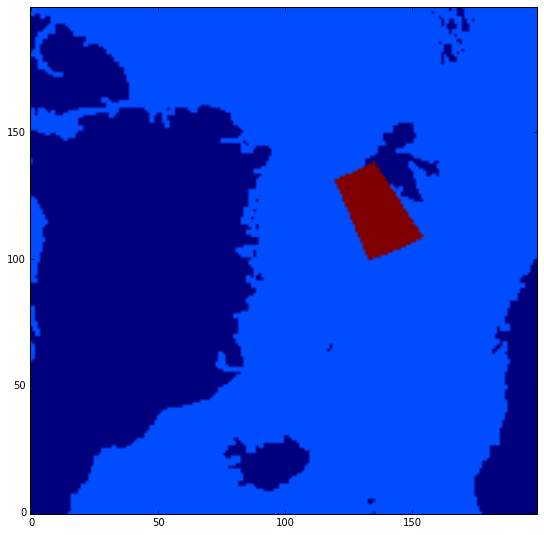

In [7]:
# Identify the area with boolean 
FraWSC_msk=(ds_grid.coords['gphit']>75.)&(ds_grid.coords['gphit']<79.5)& \
        (ds_grid.coords['glamt']>2.) & (ds_grid.coords['glamt']<13.)

# Then define a mask with either 0 or 1 values
ds_grid['FraWSC_msk']=xr.where(FraWSC_msk,1.,0.)

ds_grid
# Control the location of the mask
plt.figure(figsize=(20,10))
#plt.subplot(121)
#plt.imshow(NorSeas_msk,origin='botom')
plt.subplot(122)
ds_grid['FraWSC_loc']=xr.where(FraWSC_msk,5.,ds_grid['tmask2D'][:,:])
plt.imshow(ds_grid['FraWSC_loc'][200:400,200:400],origin='botom')



>>> 

In [8]:
!date

Mon Jan 14 09:55:37 UTC 2019


# Surface net Heat fluxes & AW max T°  

In [9]:
# Ref experiment data
DATA_PATH='/home/ctalandi/TOOLS/SSHFS/drakkarcom/'+CONFIG+'/'+'CREG025.L75-'+case_Ref+'-MEAN/1m/'+RYEAR+'/'
ds_RefQ=xr.open_mfdataset(DATA_PATH+'CREG025.L75-'+case_Ref+'_y*m*.1m_flxT.nc',autoclose=True)
ds_RefIce=xr.open_mfdataset(DATA_PATH+'CREG025.L75-'+case_Ref+'_y*m*.1m_icemod.nc',autoclose=True)
ds_RefgT=xr.open_mfdataset(DATA_PATH+'CREG025.L75-'+case_Ref+'_y*m*.1m_gridT.nc',autoclose=True)
monthly_time=pd.date_range(start=str(s_year)+'-01-01',end=str(e_year)+'-12-31',freq='M')

### Compute the AW max T

In [10]:
def AWTmax_maps(ds,ds_grid) :

        dsout=xr.Dataset()
        # Start to mask field where Salinity is lower than 33.5 PSU
        # Necessary to remove the surface temperature maxima than can arise
        dsout['temp']=xr.where((ds['vosaline'] <= 33.5),0., ds['votemper'])

        # Find the Max temp. over depth
        dsout['AWTmax']=dsout['temp'].max(dim='deptht')*ds_grid['tmask2D'][:,:]

        # Find the Max temp. depth level 
        #dsout['AWTmax_depth_level']=dsout['temp'].argmax(dim='deptht')

        return dsout

In [11]:
#plt.figure(figsize=(20,15))

#vmin=-100. ; vmax=100. ; vint=20.
#contours=np.arange(vmin,vmax+vint,vint)
#limits=[vmin,vmax]      
#cregmap.WSC_plot(lon,lat,ds_RefQ.hfxout.mean(dim='time_counter'),ds_RefIce.siconc.mean(dim='time_counter'),ds_grid,contours,limits)

In [12]:
ds_diagsAW=AWTmax_maps(ds_RefgT,ds_grid)

In [13]:
ds_diagsAW

<xarray.Dataset>
Dimensions:       (deptht: 75, time_counter: 432, x: 528, y: 603)
Coordinates:
  * deptht        (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * time_counter  (time_counter) datetime64[ns] 1980-01-16T11:58:56 ... 2015-12-16T12:01:04
    gphif         (y, x) float32 25.4716 25.471653 ... 55.095528 55.02518
    glamf         (y, x) float32 -93.62534 -93.37534 ... 102.25591 102.051285
    gphit         (y, x) float32 25.359825 25.359877 ... 55.021885 54.95175
    glamt         (y, x) float32 -93.75031 -93.50031 ... 102.193756 101.988945
Dimensions without coordinates: x, y
Data variables:
    temp          (time_counter, deptht, y, x) float32 dask.array<shape=(432, 75, 603, 528), chunksize=(1, 75, 603, 528)>
    AWTmax        (time_counter, y, x) float32 dask.array<shape=(432, 603, 528), chunksize=(1, 603, 528)>

In [14]:
# Plot the Qnet and contrast 2 periods JFM with JAS
# For that:
#       - groupby month and perform a mean over all months
#       - select months to gather to build JFM and JAS seasons
ds_RefQ_seas=ds_RefQ.hfxout.groupby('time_counter.month').mean('time_counter')
ds_RefQ_seas_JFM=ds_RefQ_seas.sel(month=slice(0,3)).mean(dim='month')
ds_RefQ_seas_JAS=ds_RefQ_seas.sel(month=slice(6,9)).mean(dim='month')

ds_RefIce_seas=ds_RefIce.siconc.groupby('time_counter.month').mean('time_counter')
ds_RefIce_seas_JFM=ds_RefIce_seas.sel(month=slice(0,3)).mean(dim='month')
ds_RefIce_seas_JAS=ds_RefIce_seas.sel(month=slice(6,9)).mean(dim='month')

ds_AWT_seas=ds_diagsAW.AWTmax.groupby('time_counter.month').mean('time_counter')
ds_AWT_seas_JFM=ds_AWT_seas.sel(month=slice(0,3)).mean(dim='month')
ds_AWT_seas_JAS=ds_AWT_seas.sel(month=slice(6,9)).mean(dim='month')

In [15]:
!date

Mon Jan 14 10:07:23 UTC 2019


In [16]:
NCsave=True
if NCsave: 
    dsout=xr.Dataset()

    # Output Qnet climatology
    dsout['ds_RefQ_seas']=(('month','y','x'),ds_RefQ_seas)
    dsout.ds_RefQ_seas.attrs['units']='W.m-2'
    dsout.ds_RefQ_seas.attrs['long name']='Surface net heat flux climatology monthly mean over '+RYEAR

    dsout['ds_RefQ_seas_JFM']=(('y','x'),ds_RefQ_seas_JFM)
    dsout.ds_RefQ_seas_JFM.attrs['units']='W.m-2'
    dsout.ds_RefQ_seas_JFM.attrs['long name']='Surface net heat flux JFM seas. mean over '+RYEAR

    dsout['ds_RefQ_seas_JAS']=(('y','x'),ds_RefQ_seas_JAS)
    dsout.ds_RefQ_seas_JAS.attrs['units']='W.m-2'
    dsout.ds_RefQ_seas_JAS.attrs['long name']='Surface net heat flux JAS seas. mean over '+RYEAR

    # Output Ice fraction climatology
    dsout['ds_RefIce_seas']=(('month','y','x'),ds_RefIce_seas)
    dsout.ds_RefIce_seas.attrs['units']='-'
    dsout.ds_RefIce_seas.attrs['long name']='Sea-ice concentration climatology monthly mean over '+RYEAR

    dsout['ds_RefIce_seas_JFM']=(('y','x'),ds_RefIce_seas_JFM)
    dsout.ds_RefIce_seas_JFM.attrs['units']='-'
    dsout.ds_RefIce_seas_JFM.attrs['long name']='Sea-ice concentration JFM seas. mean over '+RYEAR

    dsout['ds_RefIce_seas_JAS']=(('y','x'),ds_RefIce_seas_JAS)
    dsout.ds_RefIce_seas_JAS.attrs['units']='-'
    dsout.ds_RefIce_seas_JAS.attrs['long name']='Sea-ice concentration JAS seas. mean over '+RYEAR

    # Output AWTmax climatology
    dsout['ds_AWT_seas']=(('month','y','x'),ds_AWT_seas)
    dsout.ds_AWT_seas.attrs['units']='-'
    dsout.ds_AWT_seas.attrs['long name']='Atlantic Water max. temperature climatology monthly mean over '+RYEAR

    dsout['ds_AWT_seas_JFM']=(('y','x'),ds_AWT_seas_JFM)
    dsout.ds_AWT_seas_JFM.attrs['units']='-'
    dsout.ds_AWT_seas_JFM.attrs['long name']='Atlantic Water max. temperature JFM seas. mean over '+RYEAR

    dsout['ds_AWT_seas_JAS']=(('y','x'),ds_AWT_seas_JAS)
    dsout.ds_AWT_seas_JAS.attrs['units']='-'
    dsout.ds_AWT_seas_JAS.attrs['long name']='Atlantic Water max. temperature JAS seas. mean over '+RYEAR
    

    dsout.to_netcdf('./NETCDF/'+case_Ref+'_y'+RYEAR+'_ClimSeas_Qt_AWTmax_IceConc.nc')

    NCsave=False

/usr/local/lib/python2.7/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python2.7/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/usr/local/lib/python2.7/dist-packages/dask/core.py:137: RuntimeWarning: All-NaN slice encountered
  return func(*args2)
/usr/local/lib/python2.7/dist-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [17]:
!date

Mon Jan 14 11:27:59 UTC 2019


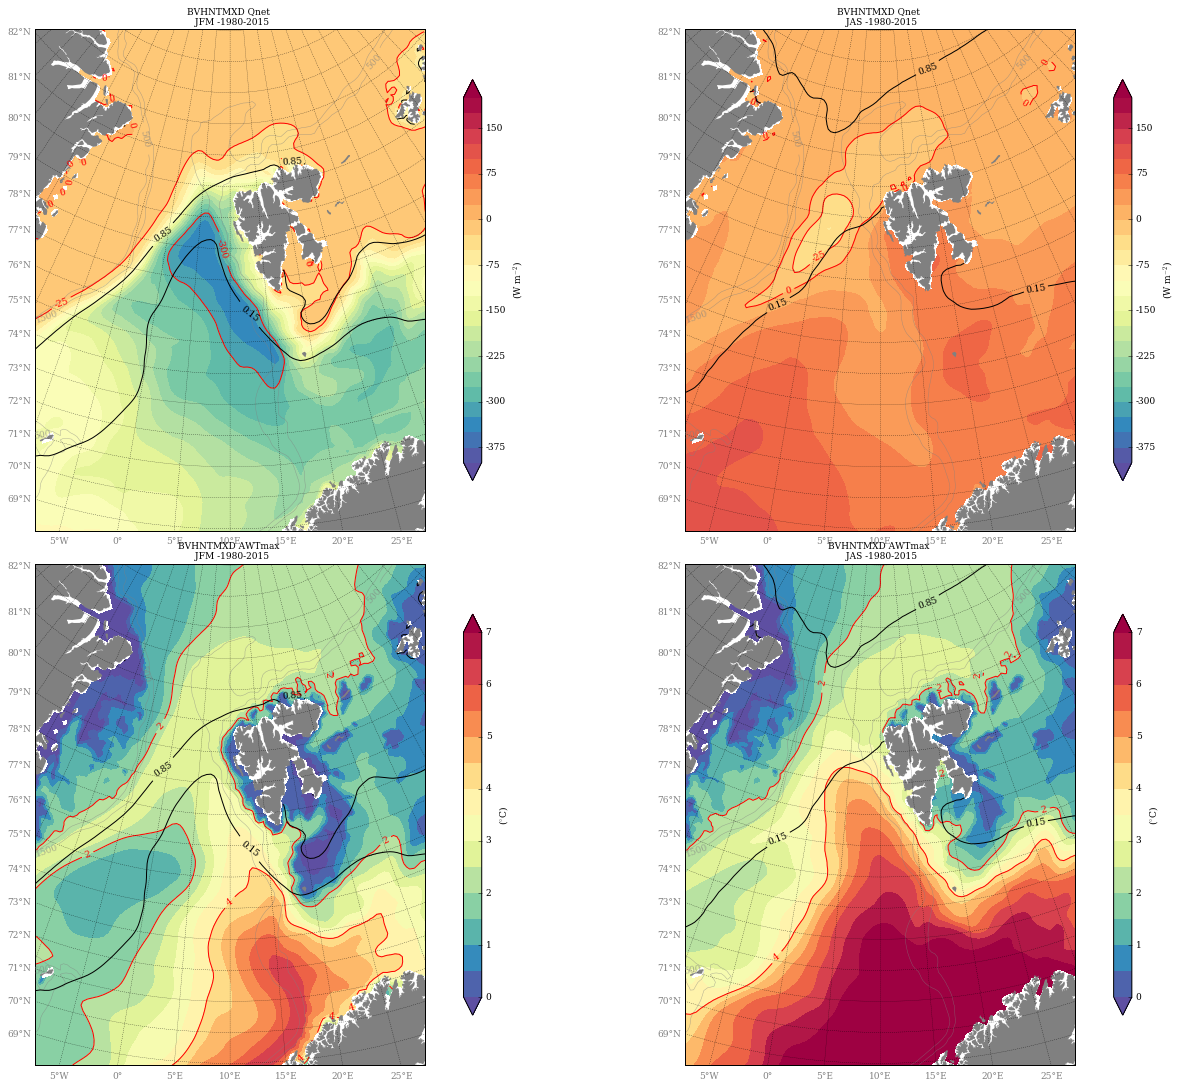

In [20]:
plt.figure(figsize=(20,15))

# Surface heat fluxes
vmin=-400. ; vmax=200. ; vint=25.
contours=np.arange(vmin,vmax+vint,vint)
limits=[vmin,vmax]      
plt.subplot(221)
cregmap.WSC_plot(lon,lat,ds_RefQ_seas_JFM,ds_RefIce_seas_JFM,ds_grid,contours,limits, \
                 name=case_Ref+' Qnet \n JFM -'+RYEAR,zmy_cblab=r'(W m$^{-2}$)',zvar='Qnet')

plt.subplot(222)
cregmap.WSC_plot(lon,lat,ds_RefQ_seas_JAS,ds_RefIce_seas_JAS,ds_grid,contours,limits, \
                 name=case_Ref+' Qnet \n JAS -'+RYEAR,zmy_cblab=r'(W m$^{-2}$)',zvar='Qnet')


# AWTmax 
vmin=0. ; vmax=7. ; vint=0.5
contours=np.arange(vmin,vmax+vint,vint)
limits=[vmin,vmax]      
plt.subplot(223)
cregmap.WSC_plot(lon,lat,ds_AWT_seas_JFM,ds_RefIce_seas_JFM,ds_grid,contours,limits, \
                 name=case_Ref+' AWTmax \n JFM -'+RYEAR,zmy_cblab=r'($^{\circ}$C)',zvar='Temp')

plt.subplot(224)
cregmap.WSC_plot(lon,lat,ds_AWT_seas_JAS,ds_RefIce_seas_JAS,ds_grid,contours,limits, \
                 name=case_Ref+' AWTmax \n JAS -'+RYEAR,zmy_cblab=r'($^{\circ}$C)',zvar='Temp')

plt.tight_layout()

dosave=True
if dosave : plt.savefig(case_Ref+'_y'+RYEAR+'_Qnet-AWTmax_JFM-JOS.pdf',dpi=100)
dosave=False


In [19]:
!date

Mon Jan 14 11:49:19 UTC 2019
